In [141]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from networkx import planar_layout

from graph import create_graph, milp_solve
from pyg import geom_data

In [142]:
ckp_path = './experiments/2024-06-02 1211/0/checkpoints/epoch=275-step=2207999.ckpt'
checkpoint = torch.load(ckp_path, map_location=torch.device('cpu'))
hyper_parameters = checkpoint['hyper_parameters']

In [143]:
from models import GNNModel

state_dict = {}
for k, v in checkpoint['state_dict'].items():
    k = k.replace('.weight', '.lin.weight').replace('model.', '')
    if 'output_layers' in k:
        v = v.T
    if k == 'layers.0.lin.weight':
        v = v.T
    state_dict[k] = v

gnn = GNNModel(c_in=hyper_parameters['c_in'], c_hidden=30, c_out=hyper_parameters['c_out'], num_layers=hyper_parameters['num_layers'], m=hyper_parameters['m'])
gnn.load_state_dict(state_dict)
gnn

GNNModel(
  (layers): ModuleList(
    (0): GCNConv(1, 30)
    (1): ReLU(inplace=True)
    (2): GCNConv(30, 30)
    (3): ReLU(inplace=True)
    (4): GCNConv(30, 30)
    (5): ReLU(inplace=True)
    (6): GCNConv(30, 30)
    (7): ReLU(inplace=True)
    (8): GCNConv(30, 30)
    (9): ReLU(inplace=True)
    (10): GCNConv(30, 30)
    (11): ReLU(inplace=True)
    (12): GCNConv(30, 30)
    (13): ReLU(inplace=True)
    (14): GCNConv(30, 30)
    (15): ReLU(inplace=True)
    (16): GCNConv(30, 30)
    (17): ReLU(inplace=True)
    (18): GCNConv(30, 30)
    (19): ReLU(inplace=True)
    (20): GCNConv(30, 30)
    (21): ReLU(inplace=True)
    (22): GCNConv(30, 30)
    (23): ReLU(inplace=True)
    (24): GCNConv(30, 30)
    (25): ReLU(inplace=True)
    (26): GCNConv(30, 30)
    (27): ReLU(inplace=True)
    (28): GCNConv(30, 30)
    (29): ReLU(inplace=True)
    (30): GCNConv(30, 30)
    (31): ReLU(inplace=True)
    (32): GCNConv(30, 30)
    (33): ReLU(inplace=True)
    (34): GCNConv(30, 30)
    (35): ReLU(i

In [314]:
n, p = 10, .45
g = create_graph(n, p)
# g = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])
edge_list = [(int(a), int(b)) for a, b in g.T]

g_n = nx.from_edgelist(edge_list)
x = torch.Tensor([[1.]] * n)
tg = geom_data.Data(x=x, edge_index=g)

In [315]:
gnn.eval()
results = gnn.forward(x, g)
maps = (torch.sigmoid(results) > .5).float()

In [316]:
mvc = milp_solve(g, n)
y = torch.FloatTensor([[n in mvc] for n in range(n)])
print(f'{mvc=}')

mvc={0, 2, 5, 6, 7, 8}


In [317]:
acc = ((maps == y).sum(dim=1) / y.size(dim=0)).max().item()
aon = (maps == y).all(dim=1).sum().float().item()

a, b = 1, 1
cov_size_dif = (maps.sum(dim=1) - y.sum())
uncovered_edges = torch.sum(
    ~(maps[:, g[0]].logical_or(maps[:, g[1]])),
    dim=1
) / 2
mvc_scores = (a * cov_size_dif.abs() + b * uncovered_edges)
idx, min_mvc = mvc_scores.argmin().item(), mvc_scores.min().item()

print(f'{acc=:.2f}\n{aon=}\n{min_mvc=} \n{cov_size_dif[idx]=} \n{uncovered_edges[idx]=}')

acc=0.80
aon=0.0
min_mvc=2.0 
cov_size_dif[idx]=tensor([2.]) 
uncovered_edges[idx]=tensor([0.])


In [318]:
prob_n = [(i, v.item()*100) for i, v in enumerate(torch.sigmoid(results[idx]))]
prob_n.sort(key=lambda x: x[1], reverse=True)
prob_n

[(7, 98.50185513496399),
 (4, 93.31278204917908),
 (3, 74.24960732460022),
 (2, 74.17276501655579),
 (6, 72.45169878005981),
 (0, 68.63539218902588),
 (5, 55.818963050842285),
 (8, 55.818963050842285),
 (1, 44.688647985458374),
 (9, 37.395766377449036)]

In [319]:
s = set()
g_ = g_n.copy()

while g_.edges:
    n_s = set()
    for v, _ in prob_n:
        if v in s | n_s or v not in g_:
            continue

        s.add(v)
        for u in list(g_.adj[v].keys()):
            n_s.add(u)

        g_.remove_node(v)

    for v in list(g_):
        if len(g_.adj[v]) == 0:
            g_.remove_node(v)

s, len(s) == len(mvc), all(u.item() in s or v.item() in s for u, v in g.T)

({1, 3, 4, 5, 6, 7}, True, True)

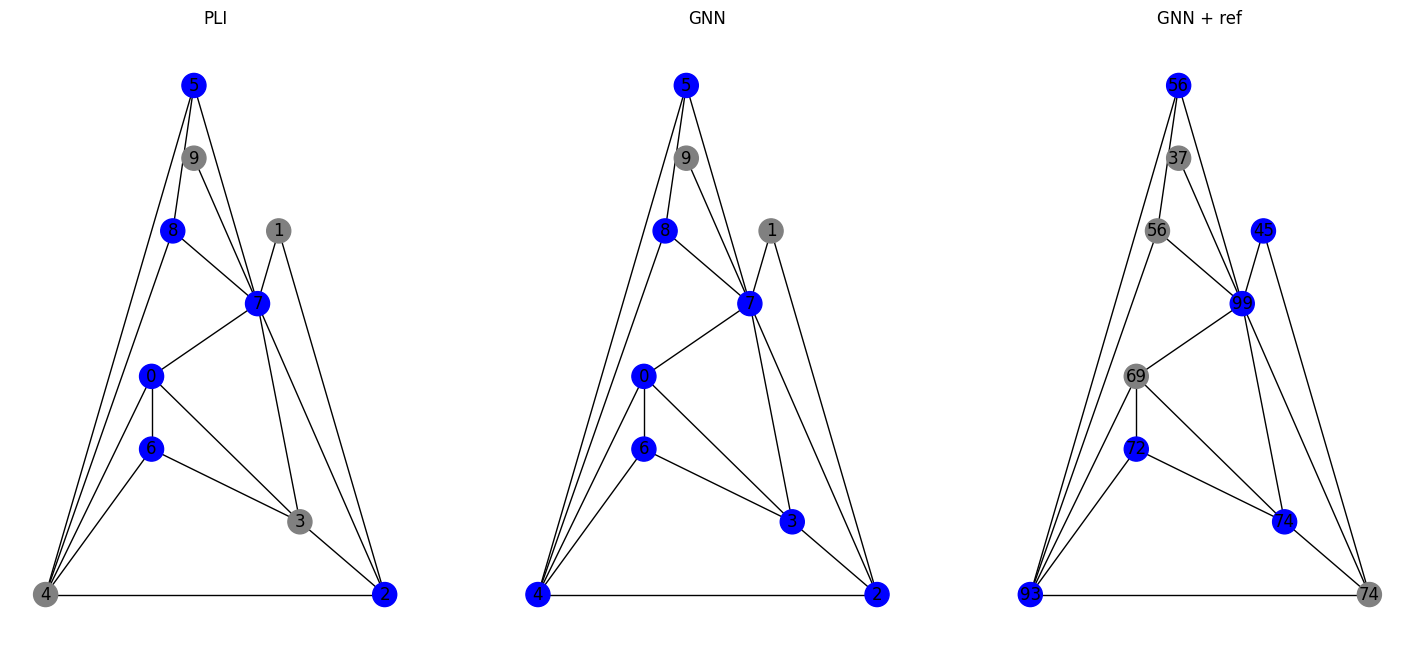

In [320]:
from copy import copy

plt.ioff()

layout = None
try:
    layout = planar_layout(g_n)
except:
    pass

fig, axes = plt.subplots(ncols=3, figsize=(18, 8))

node_colors = ['blue' if n in mvc else 'gray' for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[0])

mvc_color = ['blue' if v else 'gray' for v in maps[idx].squeeze()]
node_colors = [mvc_color[n] for n in g_n]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[1])

mvc_color = ['blue' if v in s else 'gray' for v in range(n)]
node_colors = [mvc_color[n] for n in g_n]
label_dict = {n: f'{v:.0f}' for n, v in prob_n}
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout, ax=axes[2], labels=label_dict)

for i, t in enumerate(['PLI', 'GNN', 'GNN + ref']):
    axes[i].set_title(t)

plt.show()

In [321]:
raise KeyError

KeyError: 

## Correct output distribution

In [322]:
from tqdm import tqdm

l = torch.nn.BCEWithLogitsLoss()
m = hyper_parameters['m']
results = [0] * m
r_l = [0] * m
x = torch.Tensor([[1.]] * n)
for i in tqdm(range(1000)):
    g = create_graph(n, p)
    edge_list = [(int(a), int(b)) for a, b in g.T]

    mvc = milp_solve(g, n)
    y = torch.FloatTensor([[n in mvc] for n in range(n)])

    g_n = nx.from_edgelist(edge_list)
    tg = geom_data.Data(x=x, edge_index=g)

    maps = gnn.forward(x, g)
    losses = [l(pb, y) for pb in maps]
    r_l_idx = min(range(m), key=lambda x: losses[x])
    r_l[r_l_idx] += 1
    maps = (torch.sigmoid(maps) > .5).float()

    a, b = 1, 1
    cov_size_dif = (maps.sum(dim=1) - y.sum()).abs()
    uncovered_edges = torch.sum(
        ~(maps[:, g[0]].logical_or(maps[:, g[1]])),
        dim=1
    )
    mvc_scores = (a * cov_size_dif + b * uncovered_edges)
    idx = mvc_scores.argmin()
    results[idx] += 1



results

100%|██████████| 1000/1000 [00:07<00:00, 137.42it/s]


[0, 0, 4, 407, 0, 213, 0, 0, 0, 376, 0, 0, 0, 0, 0, 0]

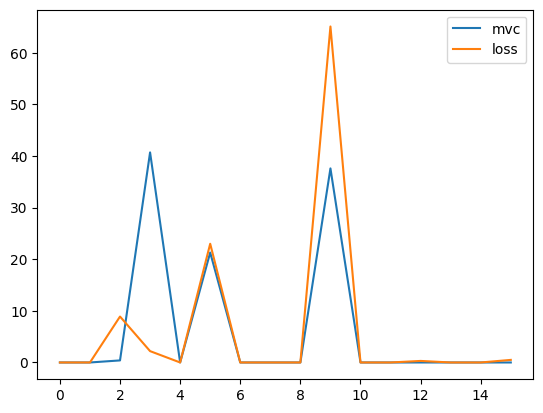

In [323]:
import pandas as pd
fig.clear()
pd.DataFrame({'mvc': [r/10 for r in results], 'loss': [r/10 for r in r_l]}).plot()
plt.show()